## Imports 📦

In [1]:
import pandas as pd
import numpy as np
import emoji
import warnings
import nltk
from nltk.corpus import stopwords    
import string
import statistics

In [2]:
from matplotlib import pyplot as plt

In [3]:
warnings.filterwarnings('ignore')

## Load Data 💿

In [4]:
df = pd.read_csv("Data/cleaned_by_language.csv")

In [5]:
en_df = df[df['language'] == 'en']
es_df = df[df['language'] == 'es']

In [6]:
en_comment = en_df['text only'].to_list()
es_comment = es_df['text only'].to_list()
en_comment_with_emoji = en_df['text'].to_list()
es_comment_with_emoji = es_df['text'].to_list()

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
en_stop_words = set(stopwords.words('english'))
es_stop_words = set(stopwords.words('spanish'))

def filter_comments(comment_list, stop_words):
    filtered_comments = []

    for comment in comment_list:
        # remove word starts with @
        comment = " ".join(filter(lambda x:x[0]!='@', comment.split()))
    
        # remove punctuations
        comment = comment.translate(str.maketrans('', '', string.punctuation))

        # remove stopwords
        words = nltk.word_tokenize(comment)
        filtered_comment = [word for word in words if word.lower() not in stop_words]
        filtered_comment = ' '.join(filtered_comment)
        filtered_comment = comment
        filtered_comments.append(filtered_comment)
    return filtered_comments

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yuhsinhuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuhsinhuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
en_filtered_comments = filter_comments(en_comment, en_stop_words)
es_filtered_comments = filter_comments(es_comment, es_stop_words)
en_with_emoji_filtered_comments = filter_comments(en_comment_with_emoji, en_stop_words)
es_with_emoji_filtered_comments = filter_comments(es_comment_with_emoji, es_stop_words)

## Text Embeddings using LASER - this pretrained model supports cross-lingual tasks and embeds in setence-level

In [9]:
pip install laserembeddings

Note: you may need to restart the kernel to use updated packages.


In [10]:
!/usr/bin/python3 -m laserembeddings download-models

/Applications/Xcode.app/Contents/Developer/usr/bin/python3: No module named laserembeddings


In [11]:
# run this in terminal first: python -m laserembeddings download-models
from laserembeddings import Laser

laser = Laser()
en_text_array = laser.embed_sentences(en_filtered_comments, lang='en')
es_text_array = laser.embed_sentences(es_filtered_comments, lang='es')
en_array = laser.embed_sentences(en_with_emoji_filtered_comments, lang='en')
es_array = laser.embed_sentences(es_with_emoji_filtered_comments, lang='es')

In [12]:
en_text_array.shape

(280, 1024)

In [13]:
en_array.shape

(280, 1024)

## Emoji Embeddings using Emoji2Vec

In [14]:
from gensim.models import KeyedVectors

# Load pretrained emoji embeddings
emoji_model = KeyedVectors.load_word2vec_format('emoji2vec.bin', binary=True)

def emoji_embedding(df):
    emoji_list_list = df['emoji list'].to_list()

    # Initialize a list to store emoji embeddings
    emoji_embedding = []

    for emoji_list in emoji_list_list:
        emoji_list_embedding = []  # Initialize a list for embeddings of each emoji list
        for emoji in emoji_list:
            try:
                emoji_list_embedding.append(emoji_model[emoji])
                
            except KeyError:
                pass

            # if len(emoji_list_embedding) != 0:
            # emoji_list_embedding = np.concatenate(emoji_list_embedding, axis=0)
        emoji_embedding.append(emoji_list_embedding)
    
    # average
    res = []
    for embeddings in emoji_embedding:
        average_embedding = np.mean(embeddings, axis=0)
        # padded arrays with zero emojis with a length 300 array filled with zeros
        if average_embedding is None or np.isnan(average_embedding).all():
            res.append(np.zeros(300))
        else:
            res.append(average_embedding)
    
    return np.array(res)

# en_max_size = max(len(arr) for arr in en_emoji_embedding)
# en_padded_arrays = [np.pad(arr, (0, en_max_size - len(arr)), 'constant') for arr in en_emoji_embedding]
# en_emoji_array = np.vstack(en_padded_arrays)

In [15]:
en_emoji_array = emoji_embedding(en_df)
es_emoji_array = emoji_embedding(es_df)

In [16]:
es_emoji_array.shape

(280, 300)

##  Testing to see how many unique emojis in each comment (Don't run this part) 🧪

In [17]:
# def emoji_embedding(df):
#     emoji_list_list = df['emoji list'].to_list()

#     # Initialize a list to store emoji embeddings
#     emoji_embedding = []
#     emoji_count = []
#     emoji_list_l = []

#     for emoji_list in emoji_list_list:
#         emoji_l = []
#         emoji_list_embedding = []  # Initialize a list for embeddings of each emoji list
#         count = 0
#         for emoji in emoji_list:
#             try:
#                 emoji_list_embedding.append(emoji_model[emoji])
#                 emoji_l.append(emoji)
#                 count+=1
                
#             except KeyError:
#                 pass
#         emoji_list_l.append(emoji_l)
#         emoji_count.append(count)

#         if len(emoji_list_embedding) != 0:
#             emoji_list_embedding = np.concatenate(emoji_list_embedding, axis=0)
#         emoji_embedding.append(emoji_list_embedding)

#     return emoji_count, emoji_embedding, emoji_list_l

In [18]:
# en_emoji_count, en_emoji_embedding, es_emoji = emoji_embedding(en_df)
# es_emoji_count, es_emoji_embedding, en_emoji = emoji_embedding(es_df)

In [19]:
# list1 = []
# for i in es_emoji:
#     unique_set = set(i)
#     unique_list = list(unique_set)
#     list1.append(unique_list)
# list1 # a list of unique emojis in each comment (that can be handled by emoji2vec)
# counts = [len(inner_list) for inner_list in list1]

# zero_count = 0

# for item in counts:
#     if item == 0:
#         zero_count += 1
# zero_count

In [20]:
# list2 = []
# for i in en_emoji:
#     unique_set = set(i)
#     unique_list = list(unique_set)
#     list2.append(unique_list)
# list2 # a list of unique emojis in each comment (that can be handled by emoji2vec)
# counts2 = [len(inner_list) for inner_list in list2]

# zero_count2 = 0

# for item in counts2:
#     if item == 0:
#         zero_count2 += 1
# zero_count2

## Concatenate the text embeddings and emoji embeddings 

In [21]:
# Concatenate along columns (horizontally)
en_embeddings = np.concatenate((en_text_array, en_emoji_array), axis=1)
es_embeddings = np.concatenate((es_text_array, es_emoji_array), axis=1)

In [22]:
en_embeddings.shape

(280, 1324)

In [23]:
es_embeddings.shape

(280, 1324)

## Variable names 📇
- en_text_array: LASER embeddings on text only (shape:280x1024)
- en_emoji_array: emoji2vec embeddings on emoji only (shape: 280x300)
- en_embeddings: concatenate en_text_array and en_emoji_array (shape: 280, 1324)
- en_array: LASER embeddings on text+emoji (shape: 280x1024)
- (replace en by es to get result from Spanish dataset)


## Try clustering using minibatch Kmeans -- concatenated word + emoji embeddings

In [24]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

### Determine optimal number of clusters

#### Distortion Score Elbow
- based on calculating the Within-Cluster-Sum of Squared Errors (WSS) for different number of clusters (k) and selecting the k for which change in WSS first starts to diminish.

In [25]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


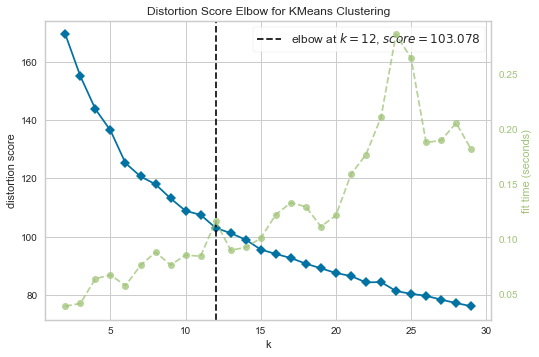

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
# referenced https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(en_embeddings)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

#### Silhouette Coefficient Method

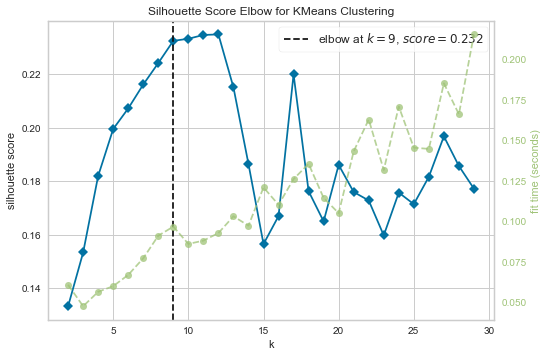

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [27]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(en_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

#### Calinski-Harabasz Index

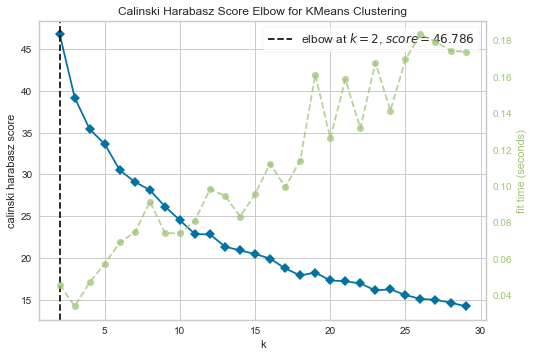

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [28]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(en_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Clustering Functions

In [29]:
# code from https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/
def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [30]:
def apply_cluster(lang_embeddings, lang_df, lang_filtered_comments, k):
    clustering, cluster_labels = mbkmeans_clusters(
        X=lang_embeddings,
        k=k,
        mb=500,
        print_silhouette_values=True,
    )
    df_clusters = pd.DataFrame({
        "text": lang_df['text'],
        "tokens": [" ".join(text) for text in lang_filtered_comments],
        "cluster": cluster_labels
    })
    return df_clusters

### English Results

In [31]:
en_df_clusters = apply_cluster(en_embeddings, en_df, en_filtered_comments, 11)

For n_clusters = 11
Silhouette coefficient: 0.23
Inertia:107.17795911632521
Silhouette values:
    Cluster 6: Size:6 | Avg:0.53 | Min:0.50 | Max: 0.54
    Cluster 2: Size:14 | Avg:0.46 | Min:0.34 | Max: 0.51
    Cluster 10: Size:6 | Avg:0.45 | Min:0.42 | Max: 0.48
    Cluster 4: Size:24 | Avg:0.44 | Min:0.10 | Max: 0.52
    Cluster 1: Size:76 | Avg:0.33 | Min:0.11 | Max: 0.40
    Cluster 7: Size:9 | Avg:0.33 | Min:0.08 | Max: 0.46
    Cluster 3: Size:24 | Avg:0.28 | Min:0.03 | Max: 0.45
    Cluster 8: Size:19 | Avg:0.22 | Min:-0.08 | Max: 0.35
    Cluster 5: Size:41 | Avg:0.20 | Min:-0.06 | Max: 0.33
    Cluster 0: Size:3 | Avg:0.11 | Min:0.09 | Max: 0.15
    Cluster 9: Size:58 | Avg:-0.08 | Min:-0.24 | Max: -0.03


Top 3 English clusters

In [32]:
en_df_clusters[en_df_clusters['cluster']==10]['text'].tolist()

['Wtf Mbappe wasn’t even the man of the match 🤦🏻\u200d♂️',
 'This is an insult\nWe lost because of their support🤦\u200d♂️',
 '@blueblink5254 dude also, I am embarrassed FOR YOU! 🤦\u200d♀️',
 'After 12 year of madness y’all couldn’t complete a simple penalty 🤦🏾\u200d♂️🤦🏾\u200d♂️',
 'Why do they always ask this question 🤦🏻\u200d♂️ Anyway everyone gives the same answer - "I would give it to the whole team" Are there any other questions?',
 "@manas.f.rollins bruh that's the Belgium flag 🤦"]

In [33]:
en_df_clusters[en_df_clusters['cluster']==4]['text'].tolist()

['We love you hazards🔥🔥🔥',
 'The France 🇫🇷 is on Fire 🔥',
 'dats literally my dad 🔥',
 'Best player 🔥🔥',
 '@pure_sh1thousery we are winer❤️❤️🔥🇮🇷🇮🇷🇮🇷🇮🇷',
 'My Favorite team 🔥🔥',
 '@nadoosh_ku I agreed with you from Saudi Arabia🔥🔥🔥',
 'Korea Vs Ghana was far better game 🔥🔥',
 'Musiala all the way🔥',
 'Rushford 🔥',
 'Nice game 🔥',
 '@beatbox_musicality For real bro🔥🔥🔥',
 'the real blue lock🙌🔥🔥😍',
 'Cool🔥',
 'Mbappe on another level in this world cup🔥🔥🔥❤️',
 'The big and champions France in Qatar2022🔥',
 '@farzad_1818 I like both team but wowwww Maroccco 🔥',
 "Thank you for entertaining me Japan, I'm waiting for the excitement again in four years👏❤️\u200d🔥🇯🇵🇯🇵❤️\u200d🔥",
 '@m.a.l.e.k.a.n.o_jr Just wait🔥',
 'Th rise of asian football ❤️❤️❤️proudly all Asian can say japan is a Asian football country...,🔥🔥🔥',
 'So much ❤️❤️❤️❤️ for CR7🔥🔥',
 'Messi wins the this exciting wc!!! 👏🔥❤️\u200d🔥',
 'Go Croatia!!🔥🔥',
 'Uff he was the best 🔥🔥😍']

In [34]:
en_df_clusters[en_df_clusters['cluster']==9]['text'].tolist()

['We are ready 💛💙❤️',
 'You are the best lady😻🤩🙏👏♥️⚽🤠fifa.',
 '@fatenalshoubaki respecting cultures goes both ways, i won\'t invite a muslim man to my house and force him to eat pork because "it\'s in my culture to eat pork", both hosts and guests should be able to respect eachother 👍',
 '👏😄 next game please..⚽🏃',
 '@glg_sky yeah I’m sure Qatar being ranked financially behind Greece means they’re thriving 🙄',
 'Fantastis group..✌😄',
 'Nice trophy..smile it..get it..your trophy..🏆✌😄',
 'This nikka sick wit it🔥😂',
 'Rainbow 🌈🌈🌈 shame on fifa',
 'Waiting next game..steady team⚽💥🏃',
 'He is our Nr 1 🇨🇭👍👍🇨🇭',
 'no bro many moroccans respect Croatia team, was a game full of fair-play 👌🏽',
 'Gay people, they are my favorite 🌈🌈',
 "@shintia97s love over hate !! I'm sorry that you've got so much anger inside for another human. But I forgive you and send you love and support. 🫂🫂🤗🤗😘😘🏳️\u200d🌈🏳️\u200d🌈",
 'But you start to tremble knowing you face Saudi Arabia 🇸🇦 😆',
 "Hazard's the only reason im 

### Spanish Results

Top 3 Spanish clusters

In [35]:
es_df_clusters = apply_cluster(es_embeddings, es_df, es_filtered_comments, 11)

For n_clusters = 11
Silhouette coefficient: 0.24
Inertia:95.53953177173707
Silhouette values:
    Cluster 5: Size:11 | Avg:0.41 | Min:0.17 | Max: 0.47
    Cluster 1: Size:67 | Avg:0.38 | Min:0.12 | Max: 0.44
    Cluster 7: Size:4 | Avg:0.37 | Min:0.25 | Max: 0.42
    Cluster 3: Size:23 | Avg:0.37 | Min:0.24 | Max: 0.44
    Cluster 2: Size:23 | Avg:0.33 | Min:0.02 | Max: 0.48
    Cluster 8: Size:5 | Avg:0.31 | Min:0.11 | Max: 0.37
    Cluster 6: Size:11 | Avg:0.29 | Min:0.02 | Max: 0.41
    Cluster 4: Size:17 | Avg:0.22 | Min:-0.07 | Max: 0.36
    Cluster 0: Size:66 | Avg:0.19 | Min:-0.03 | Max: 0.29
    Cluster 10: Size:17 | Avg:0.02 | Min:-0.18 | Max: 0.13
    Cluster 9: Size:36 | Avg:-0.07 | Min:-0.16 | Max: -0.01


In [36]:
pip install translate

Note: you may need to restart the kernel to use updated packages.


In [37]:
from translate import Translator

In [38]:
translator = Translator(from_lang="es", to_lang='en')
# es_df_clusters['translation'] = es_df_clusters['text'].apply(lambda x: translator.translate(x))

In [39]:
# es_df_clusters[es_df_clusters['cluster']==3]['translation'].tolist()
es_df_clusters[es_df_clusters['cluster']==3]['text'].tolist()

['Con todo maes 🔥🇨🇷',
 'Te amamos @yosoy8a 🇲🇽🔥',
 'Vamos España 🔥',
 '@sandra_cariel cameeron 100% éliminer 🔥🔥',
 '@hoonjy ustedes, si esos tiros no hirviesen pegado en el palo uffff🔥',
 'Seraaa que rompen la maldición🔥🔥🔥',
 'Valencia🔥🔥🔥',
 'Toda mí fe para la Argentina 🔥',
 '@pablogavi buena suerte🔥',
 'Volvió el MESSIAS 🇦🇷🇦🇷🇦🇷🇦🇷🇦🇷🇦🇷 Vamos Selección 🔥🔥🔥',
 'Ronaldo🔥🔥🔥🔥',
 'Aidouni🔥❤️',
 '@hilla_loaiza que nivel 🔥🔥🔥',
 'Que partidazo el de este señor🔥',
 'El mejor del mundo mundial! ❤️\u200d🔥❤️\u200d🔥',
 '😍ñ🔥🔥🔥',
 'ComOn argentina..you can do it 🔥❤️🔥',
 'Vamos Argentina 🔥🔥',
 'Fue un partido exquisito 🔥',
 'Gano Argentina 🔥🔥🔥❤️❤️❤️',
 'Argentina, Alvares🔥',
 '🔥Argentina.  3 🔥  Francia  1🔥',
 'Roberto 🔥🔥']

In [40]:
# es_df_clusters[es_df_clusters['cluster']==1]['translation'].tolist()
es_df_clusters[es_df_clusters['cluster']==1]['text'].tolist()

['Que seductor el de la segunda foto 😂😂',
 '@magggitomcruz ya estamos en la copa, se llama USA 🇺🇸 lmao p3nd3j0 😂😂',
 'Osea el uno tapa penal el otro hace gol y este es el mejor del partido es lo de ayer Ferrán hizo los 2 goles y grande jugadas y el mejor fue Gavi 😂😂',
 '@daje_mitico 😂😂',
 '@lauhernandezchavez La Payasada Les salió caro 😂',
 'Poor guy 😂',
 'Ecuador los hizo bailar los humilló y supuestamente este quedé como mejor jugador 😂 tras que anulan  un gol legítimo, también meten mano en el mejor jugador cuando todo el mundo se dió cuenta perfectamente que Ecuador los superó, que descarados que son',
 '😂 Ronaldo',
 'Se mueve más una cucaracha con baygon😂',
 '@jomiguelrivera el gol del siglo se lo hicimos a italia😂',
 'Que buen negocio el de nuestra selección 😂',
 'Mierda 😂😂😂😂😂😂😂😂',
 '@bertonrayhs_ 😂😂😂la tenes adentro🇦🇷🇦🇷',
 'Los de Arabia Saudí se quieren morir estaban contentos porque nos ganaron el primer partido 😂😂😂 vamos Argentina 🇦🇷🇦🇷',
 '@chucuzilla la mas grande conquista 

In [41]:
# es_df_clusters[es_df_clusters['cluster']==8]['translation'].tolist()
es_df_clusters[es_df_clusters['cluster']==8]['text'].tolist()

['@ezebtm suerte hermano albiceleste acá bancamos a leo y riquelme!!!🙏🏼❤️vamos argentina! saludos y éxitos desde ❤️🇨🇷pura vida',
 '@lucaasperee estado narco hahahahah Se nota lo mal informado ... y la gastronomía Mexicana no le envidia nada a la Italiana por eso es considera una de las Mejores y ni se diga De Sus paisajes y Hermosas Playas por eso esta en el Top 3 de Turismos 😇😇😇 Y gracias a Dios Vivo en Texas Mi compañía genera muyy bien $$$$$ y me la paso viajando por Mexico y donde yo quiera gracias a Dios 🙏🏾',
 'FIFA devolveme el fútbol!!🙏',
 'Por favor intercedan para q no ejecuten al jugador iraní "🙏🙏🙏🙏🙏',
 'Meastro 🙏❤️']

## Clustering with LASER Embeddings on text only

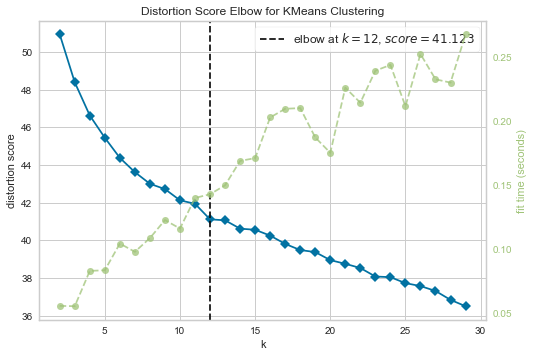

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
# referenced https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(en_text_array)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

In [43]:
en_df_clusters_laser = apply_cluster(en_text_array, en_df, en_filtered_comments, 10)

For n_clusters = 10
Silhouette coefficient: 0.03
Inertia:42.81169891357422
Silhouette values:
    Cluster 2: Size:20 | Avg:0.19 | Min:0.03 | Max: 0.32
    Cluster 3: Size:9 | Avg:0.08 | Min:-0.04 | Max: 0.20
    Cluster 9: Size:58 | Avg:0.06 | Min:-0.03 | Max: 0.12
    Cluster 7: Size:39 | Avg:0.04 | Min:-0.06 | Max: 0.13
    Cluster 4: Size:25 | Avg:0.03 | Min:-0.05 | Max: 0.11
    Cluster 1: Size:4 | Avg:0.02 | Min:0.01 | Max: 0.04
    Cluster 5: Size:44 | Avg:-0.00 | Min:-0.06 | Max: 0.07
    Cluster 8: Size:14 | Avg:-0.01 | Min:-0.03 | Max: 0.02
    Cluster 6: Size:18 | Avg:-0.01 | Min:-0.04 | Max: 0.03
    Cluster 0: Size:49 | Avg:-0.02 | Min:-0.09 | Max: 0.06


In [44]:
en_df_clusters_laser[en_df_clusters_laser['cluster']==3]['text'].tolist()

["Asian's the best🇧🇭🇮🇷🇯🇵🇰🇷🇸🇦🇭🇲😍💪💪💪",
 '@pure_sh1thousery we are winer❤️❤️🔥🇮🇷🇮🇷🇮🇷🇮🇷',
 'Dude… YOUR team was so rude and had poor sportsmanship. This new generation think they are entitled😡 Any other country would have been honored to be in the world cup to play on the same field with these GREAT players from 🇭🇷 \n\nI hope this humbles them. Canada player were acting like little brats. Croatia shut them up and put them on time out. Literally OUT😂💪🏻🇭🇷🇭🇷🇭🇷🇭🇷🇭🇷🇭🇷🏆🏆🏆🏆⚽️⚽️⚽️🇭🇷🇭🇷🇭🇷🇭🇷🇭🇷🇭🇷🇭🇷🇭🇷🇭🇷',
 'Shout out to my boy @richarlison with the best goal in this world cup 2022👏🔥🇧🇷🇧🇷🇧🇷🇧🇷',
 '@yessin99 in the round of 16 after beating tunisia and denmark 💚💛🇦🇺🇦🇺🇦🇺🇦🇺🇮🇱🦘🦘',
 'Missing Italy in the world cup😍😍😍🇮🇹🇮🇹🇮🇹',
 '@qu_een_ora can and help me to celebrate 🎉 dear sister 🇨🇲🇨🇲🇨🇲🇨🇲🇨🇲🇨🇲🇨🇲🇨🇲',
 "Thank you for entertaining me Japan, I'm waiting for the excitement again in four years👏❤️\u200d🔥🇯🇵🇯🇵❤️\u200d🔥",
 "@felicitassanto02 we're proud of our team! We still have 5 ⭐️ and nobody can take that away from us

In [45]:
en_df_clusters_laser[en_df_clusters_laser['cluster']==4]['text'].tolist()

["Can't wait for this shitshow to be over and for next world cup. This one is such a waste 🗑 🙄. #nextplease #notoqatar2022 #boicotworldcup",
 '@fatenalshoubaki respecting cultures goes both ways, i won\'t invite a muslim man to my house and force him to eat pork because "it\'s in my culture to eat pork", both hosts and guests should be able to respect eachother 👍',
 "@tiago.rendas2 bro I do know football but yesterday match that wasn't an offside lol 🤣🤣🤣what cause the camera showed his leg over the line but have you seen the last defender in the box 🤣🤣🤣go and learn football then come back chat to me",
 'Congrats and well done to🇧🇪@belgianreddevils who wins and wish the best and good luck too in the next match against🇲🇦@equipedumaroc and for🇨🇦@canadasoccer ,well done for fights until the end despite lost and wish the best and good luck too in the next match against🇭🇷@hns_cff !👏🙂😀😄😎👍⚽️',
 "@shintia97s love over hate !! I'm sorry that you've got so much anger inside for another human. But

In [46]:
en_df_clusters_laser[en_df_clusters_laser['cluster']==6]['text'].tolist()

['@bf_steve Who do you think I cheer for 😂',
 '@dashotb the comment I was looking for 😂',
 'Bro was forced to do it😂😂😂😂😂',
 'dats literally my dad 🔥',
 'De Paul always with him 😂',
 'VAR only works for certain countries it seems 😢',
 '@nadoosh_ku I agreed with you from Saudi Arabia🔥🔥🔥',
 'They themselves said it portugal sui😂😂',
 'Did he score in this video 🤣',
 '@marley4reall all that just to tie with the us😂',
 '@ziyad_hemmi got me there 😢 that penalty man',
 'Brazils back that way⬅️',
 '@yousselhak ok will see with France 😝😘',
 'Appreciate to the Admin❤️ who always updated us',
 '@sarou_lifestyle and you were right , they made history ♥️♥️',
 'Kids that never have to worries about money…..🤘🏻😆',
 '@_pierolb_ «\xa0I learned to think all by myself\xa0» 🤓😰',
 '@kunchan_13 And that happened... Wht a moment.. Historic... 🏆🐐']

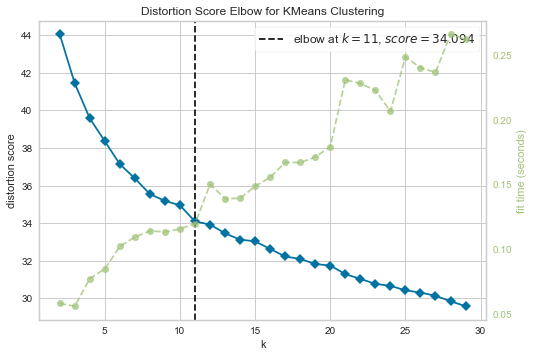

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(es_text_array)        # Fit data to visualizer
visualizer.show()     

In [48]:
es_df_clusters_laser = apply_cluster(es_text_array, es_df, es_filtered_comments, 8)

For n_clusters = 8
Silhouette coefficient: 0.06
Inertia:36.11869430541992
Silhouette values:
    Cluster 7: Size:26 | Avg:0.26 | Min:0.12 | Max: 0.44
    Cluster 2: Size:9 | Avg:0.12 | Min:-0.10 | Max: 0.24
    Cluster 4: Size:37 | Avg:0.10 | Min:0.03 | Max: 0.18
    Cluster 1: Size:66 | Avg:0.05 | Min:-0.04 | Max: 0.12
    Cluster 6: Size:49 | Avg:0.03 | Min:-0.10 | Max: 0.12
    Cluster 0: Size:27 | Avg:0.02 | Min:-0.06 | Max: 0.11
    Cluster 3: Size:9 | Avg:0.01 | Min:-0.04 | Max: 0.05
    Cluster 5: Size:57 | Avg:-0.02 | Min:-0.08 | Max: 0.06


In [49]:
# es_df_clusters_laser['translation'] = es_df_clusters_laser['text'].apply(lambda x: translator.translate(x))

In [50]:
es_df_clusters_laser[es_df_clusters_laser['cluster']==3]['text'].tolist()

['love banget idola saya portugal - cristiano ronaldo.😍',
 '@magggitomcruz ya estamos en la copa, se llama USA 🇺🇸 lmao p3nd3j0 😂😂',
 '@hoonjy ustedes, si esos tiros no hirviesen pegado en el palo uffff🔥',
 '@chucuzilla la mas grande conquista de Vargentina against Brasil ? 😂👌🏼 Pelé es maior que lá Vargentina 😂',
 '@hugoalejandrobm tenías que ser mexicano JAJA, solo México y Chile apoyaba a polonia 🤣🤫.',
 '😂😂 cara de perro chihuahua  golazo que iso jaja',
 'Gracias por todo Cristiano Ronaldo! El mejor jugador y atleta de la Historia de la Humanidad! 👏🏼👏🏼💪🏻💪🏻',
 'Neymar Da Silva Santos Junior 😢',
 'Ronaldo siempre un genio!! Ronaldo es argentino😂 es de todos!!!']

In [51]:
es_df_clusters_laser[es_df_clusters_laser['cluster']==1]['text'].tolist()

['@carlos_arte24 no se porque but I love the jersey 🥶',
 '👏👏vamos con todo, strong',
 '@ikercasillasrules No veo donde sale neuer en el video 😮',
 'Que seductor el de la segunda foto 😂😂',
 'Como molan mis negritos 😢',
 '🤫 tranki nomás, todavía no está todo dicho',
 '¡El mago maestro🔥🔥🤍👏🏻⚡',
 'ya esta viejo el cucho ☹☹',
 'Pero no hicieron nada hoy...Qué partido más aburrido 😒',
 '@bbsitaj ya vamos a ver el 18 de diciembre 😉',
 'Te amamos @yosoy8a 🇲🇽🔥',
 'La vida cambia cuando empieza a enfocarse en ti🎶🔥',
 '@lauhernandezchavez La Payasada Les salió caro 😂',
 'El mejor de todos ❤️👏',
 'Seraaa que rompen la maldición🔥🔥🔥',
 'Toda mí fe para la Argentina 🔥',
 '@letigallo mis respetos para las mujeres en todas partes🙌 💕',
 'Lamentablemente lo vi 😔',
 'Que buen negocio el de nuestra selección 😂',
 '"Maurice ya no puedo moverlo mover moverlo" ❌🦵😭',
 '@pablogavi buena suerte🔥',
 'El mejor del mundo 👏🏻 😍',
 'la araña que pica🤘🏻🕷️',
 'Lo re sentamos al polaco😂',
 '@fabilleao cállate la boca anda

## Clustering with LASER Embeddings on text + emoji

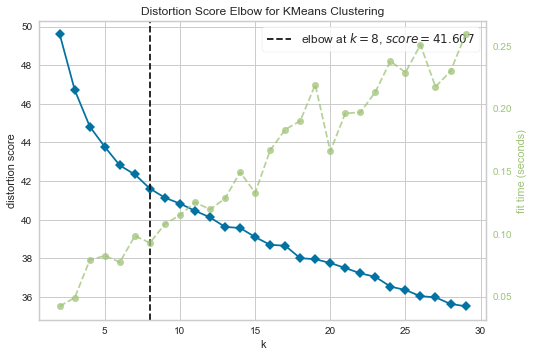

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(en_array)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

In [53]:
en_df_clusters_laser_with_emoji = apply_cluster(en_array, en_df, en_filtered_comments, 8)

For n_clusters = 8
Silhouette coefficient: 0.03
Inertia:42.37601089477539
Silhouette values:
    Cluster 1: Size:4 | Avg:0.17 | Min:0.08 | Max: 0.22
    Cluster 6: Size:3 | Avg:0.07 | Min:0.05 | Max: 0.10
    Cluster 0: Size:22 | Avg:0.07 | Min:0.01 | Max: 0.22
    Cluster 2: Size:65 | Avg:0.07 | Min:-0.02 | Max: 0.17
    Cluster 3: Size:9 | Avg:0.04 | Min:-0.02 | Max: 0.09
    Cluster 5: Size:78 | Avg:0.03 | Min:-0.11 | Max: 0.07
    Cluster 7: Size:57 | Avg:0.01 | Min:-0.08 | Max: 0.09
    Cluster 4: Size:42 | Avg:-0.02 | Min:-0.07 | Max: 0.04


In [54]:
en_df_clusters_laser_with_emoji[en_df_clusters_laser_with_emoji['cluster']==1]['text'].tolist()

['Musiala all the way🔥',
 'Brazils back that way⬅️',
 '@leobrajkovic2 Airport, this way ✈️🤣',
 '@twinty_999  airport this way 🤣👍🏻']

In [55]:
en_df_clusters_laser_with_emoji[en_df_clusters_laser_with_emoji['cluster']==5]['text'].tolist()

['We are ready 💛💙❤️',
 'TERANGA boys 🇸🇳🇸🇳❤️',
 '👏😄 next game please..⚽🏃',
 'Netherlands👏👏👏 and also cricket',
 'Nice trophy..smile it..get it..your trophy..🏆✌😄',
 'Rainbow 🌈🌈🌈 shame on fifa',
 '@dhofar_photo 🏳️\u200d⚧️☪️🏳️\u200d🌈',
 'We love you hazards🔥🔥🔥',
 'Gay people, they are my favorite 🌈🌈',
 'Definitely!!! 👏👏👏👏👏',
 'But you start to tremble knowing you face Saudi Arabia 🇸🇦 😆',
 "Hazard's the only reason im a chelsea fan 🐐💙",
 'The France 🇫🇷 is on Fire 🔥',
 '@the_queen_of_adventure Haya bina ila lmondial 😂🇨🇲😍',
 'This is an insult\nWe lost because of their support🤦\u200d♂️',
 'Best player 🔥🔥',
 'Once a player , always a player .To all such best players 🍷⚽💯💪',
 'I really wanna join them but I’m a Chinese😭😭😭',
 'Brilliant player 👏🔥',
 'My Favorite team 🔥🔥',
 'Morroco is the best 🇲🇦🖤',
 '@nadoosh_ku I agreed with you from Saudi Arabia🔥🔥🔥',
 'Korea Vs Ghana was far better game 🔥🔥',
 '@kourosh_offiziell who has more has 5 ⭐️⭐️⭐️⭐️⭐️🤫',
 'The second golden age for the socceroos 🇦🇺🟡🟢',


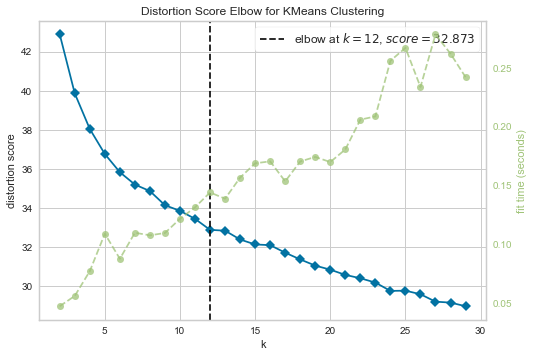

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [56]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(es_array)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

In [57]:
es_df_clusters_laser_with_emoji = apply_cluster(es_array, es_df, es_filtered_comments, 8)

For n_clusters = 8
Silhouette coefficient: 0.05
Inertia:35.076744079589844
Silhouette values:
    Cluster 6: Size:9 | Avg:0.15 | Min:0.01 | Max: 0.26
    Cluster 1: Size:54 | Avg:0.15 | Min:0.05 | Max: 0.24
    Cluster 5: Size:66 | Avg:0.09 | Min:-0.02 | Max: 0.20
    Cluster 7: Size:5 | Avg:0.04 | Min:-0.00 | Max: 0.08
    Cluster 4: Size:57 | Avg:0.01 | Min:-0.05 | Max: 0.09
    Cluster 3: Size:22 | Avg:-0.01 | Min:-0.05 | Max: 0.04
    Cluster 0: Size:24 | Avg:-0.01 | Min:-0.08 | Max: 0.05
    Cluster 2: Size:43 | Avg:-0.03 | Min:-0.12 | Max: 0.06


In [58]:
es_df_clusters_laser_with_emoji[es_df_clusters_laser_with_emoji['cluster']==3]['text'].tolist()

['@alvarodnl Si no vemos el mundial, Qatar pierde plata q ganó dejando a personas morir 🙃',
 'Osea el uno tapa penal el otro hace gol y este es el mejor del partido es lo de ayer Ferrán hizo los 2 goles y grande jugadas y el mejor fue Gavi 😂😂',
 '@axl_slash3  no me hago arg. Soy. Pero estamos hablando de Ecuador no? La selección es hoy 💙 Ganar o morir.',
 '@fifaworldcup 🇪🇨 jugó mucho mejor 😎 le anularon un gol legítimo 😠 tenía que haber ganado el partido 👏 pero vamos mi 🇪🇨 Si Se Puede y Siempre se Podrá 💪',
 '@charlywolfph naaaaa, es sólo una opinión que se desprende de la lógica y sentido común... no me interesa ser DT aunque te lo agradezco mucho... "máquina" 👍🏼😏',
 '👏👏Vamos ticos que si se puede , recurren cuando salieron del grupo de la muerte en el 2014  cuando todos los daban por muertos y los muertos resultaron ser otros . Vamos ticos que aún que mi equipo es USA pero mi corazón se lo ganaron en aquel mundial 2014 . Sino es mi USA son ustedes para mi . ❤️',
 'Los de Arabia Saudí

In [59]:
es_df_clusters_laser_with_emoji[es_df_clusters_laser_with_emoji['cluster']==4]['text'].tolist()

['@carlos_arte24 no se porque but I love the jersey 🥶',
 '@ikercasillasrules No veo donde sale neuer en el video 😮',
 'Que seductor el de la segunda foto 😂😂',
 '🤫 tranki nomás, todavía no está todo dicho',
 'ya esta viejo el cucho ☹☹',
 'Pero no hicieron nada hoy...Qué partido más aburrido 😒',
 'Siempre me han gustado lo uniformes de ghana😍',
 'La vida cambia cuando empieza a enfocarse en ti🎶🔥',
 '@lauhernandezchavez La Payasada Les salió caro 😂',
 'Se mueve más una cucaracha con baygon😂',
 '@letigallo mis respetos para las mujeres en todas partes🙌 💕',
 '@mindimalist aquí estamos mana, apoyándolos hasta el final ❤️',
 '@jomiguelrivera el gol del siglo se lo hicimos a italia😂',
 'Que buen negocio el de nuestra selección 😂',
 '#YNWA te amamos Capitán ❤️',
 'Aunque les duele el mejor Goleador✍️❤️',
 'ecuador: Brujería 🤬🤬🤬😨😨😓😥😥😭😭😭😭',
 'Lo re sentamos al polaco😂',
 '@diegoo_menendezz no hubo error en el VAR, NO LLOREN DINOS😂😂😂😂',
 '@_ab_do_r.c.a Marruecos fuera de la fifa el día 6😂😂😂',
 'Lo